# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import heapq
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_8958/819540949.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_8958/819540949.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace_raw.png')


Size of the map: (1000, 1000)
Occupied Cells: 839641
Free Cells: 160359


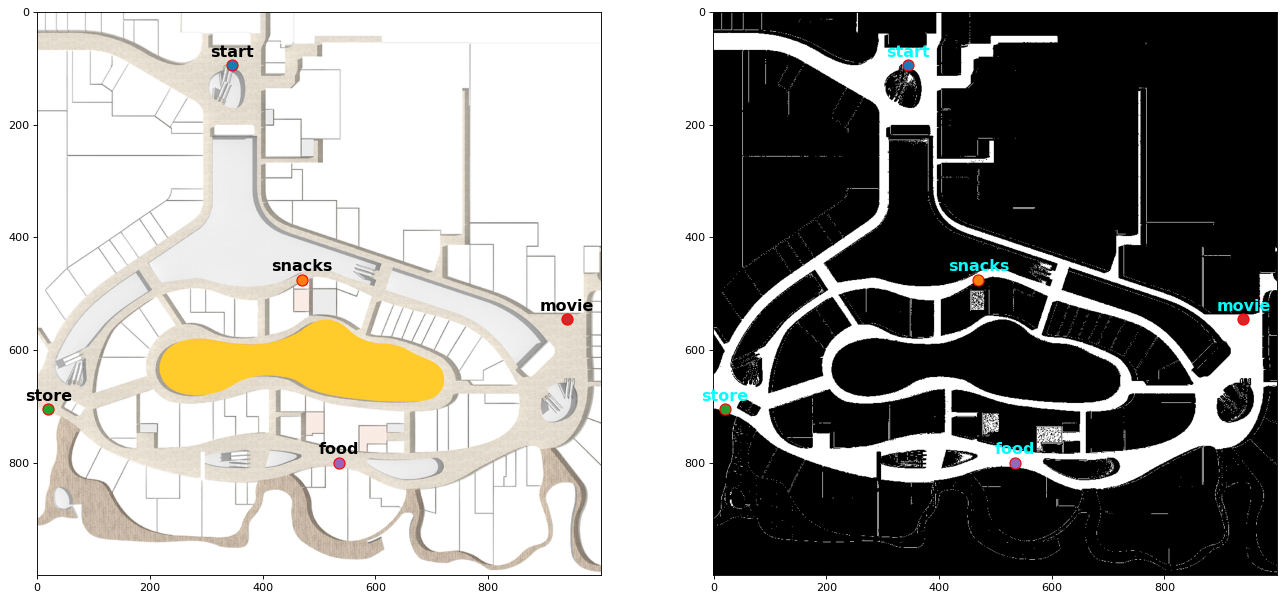

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace_raw.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
grid_map_img[921, 533]=0
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

**Check if the location is clear**

path length is 154.8763635436047
[(469, 475), (468, 475), (467, 475), (466, 475), (465, 475), (464, 475), (463, 475), (462, 475), (461, 475), (460, 475), (459, 475), (458, 475), (457, 475), (456, 475), (455, 475), (454, 475), (453, 475), (452, 475), (451, 475), (450, 475), (449, 475), (448, 475), (447, 475), (446, 476), (445, 476), (444, 477), (443, 478), (442, 479), (441, 480), (440, 481), (439, 482), (438, 483), (437, 484), (436, 485), (435, 486), (434, 487), (433, 487), (432, 487), (431, 487), (430, 487), (429, 487), (428, 487), (427, 487), (426, 487), (425, 487), (424, 487), (423, 487), (422, 487), (421, 487), (420, 487), (419, 487), (418, 487), (417, 487), (416, 487), (415, 487), (414, 487), (413, 487), (412, 487), (411, 487), (410, 487), (409, 487), (408, 487), (407, 487), (406, 487), (405, 487), (404, 487), (403, 487), (402, 487), (401, 487), (400, 487), (399, 487), (398, 487), (397, 487), (396, 487), (395, 487), (394, 487), (393, 487), (392, 487), (391, 487), (390, 487), (389, 

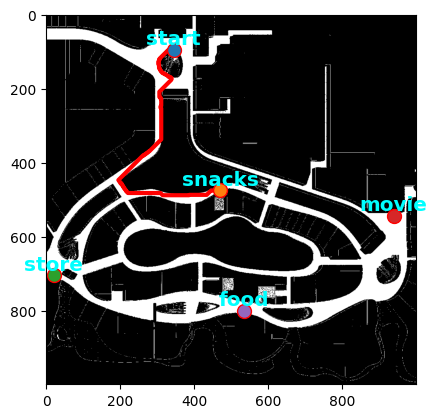

In [3]:
# For each step, if it's diagonal, distance is sqrt(2) times cell side length.
# For straight (horizontal or vertical) moves, distance equals cell side length.
def calculate_path_length(path):
    length = 0
    for i in range(1, len(path)):
        dx = abs(path[i][0] - path[i-1][0])
        dy = abs(path[i][1] - path[i-1][1])
        if dx == 1 and dy == 1:
            length += 0.2 * (2**0.5)  # Distance for diagonal moves.
        else:
            length += 0.2 * (dx + dy)  # Distance for straight moves.
    return length

# Adjust the heuristic function to use Euclidean distance
def euclidean_heuristic(a, b):
    """Calculate the Euclidean distance between two points."""
    (x1, y1) = a
    (x2, y2) = b
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# Define the A* search algorithm with Euclidean distance heuristic
def astar_search_euclidean(start, goal, array):
    """Perform A* search from start to goal using Euclidean heuristic."""
    neighbor_points = [(1, 0, 0.2), (0, 1, 0.2), (-1, 0, 0.2), (0, -1, 0.2),
                       (1, 1, 0.282), (-1, -1, 0.282), (1, -1, 0.282), (-1, 1, 0.282)]
    
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: euclidean_heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))
    
    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]  # reverse path

        close_set.add(current)
        for i, j, cost in neighbor_points:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + cost
            
            if 0 <= neighbor[1] < array.shape[0] and 0 <= neighbor[0] < array.shape[1]:
                if array[neighbor[1]][neighbor[0]] != 255:  # Check if the neighbor is free
                    continue
            else:
                # Out of bounds
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + euclidean_heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))
                
    return False

# Check if the modified algorithm solves the timeout issue by running it for a single pair
test_path = astar_search_euclidean(tuple(locations['snacks']), tuple(locations['start']), grid_map_img) # astar_search_euclidea(from, to, array)
path_length = calculate_path_length(test_path)
print(f'path length is {path_length}')
print(test_path)

x, y = zip(*test_path)
plt.plot(x, y, color='red',linewidth=3)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

## Task 2

## Brute Force Algorithms

The optimal route is ('start', 'store', 'food', 'movie', 'snacks', 'start') with a distance of 660.000 units.


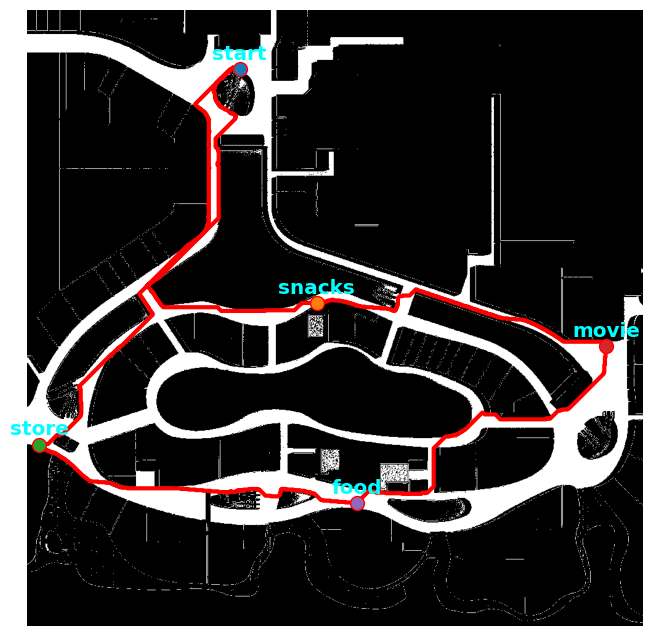

In [4]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Given distances between nodes
distances = {
    ('start', 'snacks'): 144.2,
    ('start', 'store'): 164,
    ('start', 'movie'): 182.6,
    ('start', 'food'): 235.7,
    ('snacks', 'start'): 154.9,
    ('snacks', 'store'): 122.8,
    ('snacks', 'movie'): 125.4,
    ('snacks', 'food'): 139.6,
    ('store', 'start'): 167.8,
    ('store', 'snacks'): 116.7,
    ('store', 'movie'): 255.5,
    ('store', 'food'): 115.5,
    ('movie', 'start'): 185.2,
    ('movie', 'snacks'): 108.2,
    ('movie', 'store'): 238.1,
    ('movie', 'food'): 202.1,
    ('food', 'start'): 237.5,
    ('food', 'snacks'): 139.8,
    ('food', 'store'): 123.5,
    ('food', 'movie'): 117.4
}

# Calculate the distance for a given route
def calculate_route_distance(route):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distances[(route[i], route[i + 1])]
    return total_distance

# Find the shortest route using Brute Force
def brute_force_tsp(start, loc):
    shortest_distance = float('inf')
    optimal_route = None
    # Generate all permutations of loc
    for perm in itertools.permutations(loc):
        # Create a full route by adding the start and end
        route = (start,) + perm + (start,)
        # Calculate the distance of the route
        current_distance = calculate_route_distance(route)
        # Update the shortest route if necessary
        if current_distance < shortest_distance:
            shortest_distance = current_distance
            optimal_route = route
    return optimal_route, shortest_distance

# Given loc
loc = ['snacks', 'store', 'movie', 'food']
start = 'start'

# Solve the TSP
optimal_route, optimal_distance = brute_force_tsp(start, loc)

# Display the results
print(f"The optimal route is {optimal_route} with a distance of {optimal_distance:.3f} units.")


# Function to aggregate all paths
def aggregate_paths(optimal_route):
    all_paths = []
    for i in range(len(optimal_route) - 1):
        start_location = optimal_route[i]
        next_location = optimal_route[i + 1]
        start_coords = tuple(locations[start_location])  # Convert to tuple
        goal_coords = tuple(locations[next_location])    # Convert to tuple
        # Assuming astar_search_euclidean function is defined to work with the given 'grid_map_img'
        path = astar_search_euclidean(start_coords, goal_coords, grid_map_img)
        all_paths.extend(path)
    return all_paths

# Aggregate paths for the optimal route
aggregated_paths = aggregate_paths(optimal_route)

# Visualize the combined path
x, y = zip(*aggregated_paths)
plt.figure(figsize=(12, 8))
plt.plot(x, y, color='red', linewidth=3)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.axis('off')  # Optional: hides the axis for a cleaner visualization
plt.show()

## K- Nearest Neighbor Algorithms

The route using nearest neighbor is ['start', 'snacks', 'store', 'food', 'movie', 'start'] with a distance of 685.100 units.


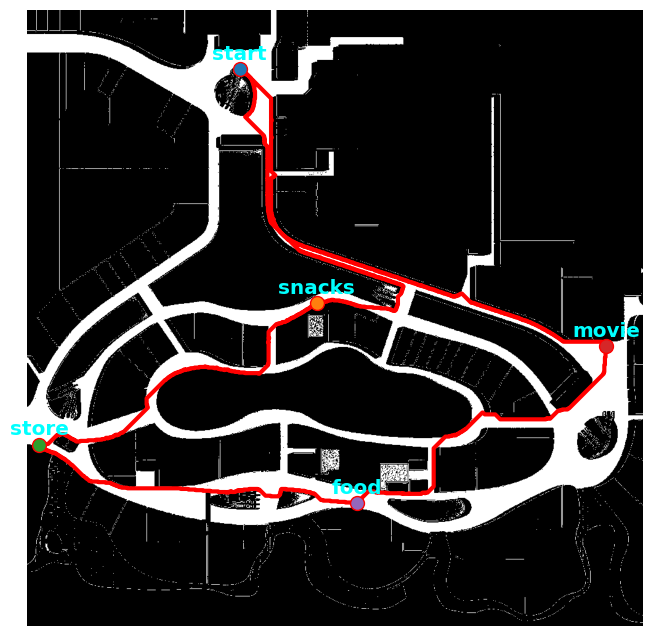

In [5]:
def nearest_neighbor(start, locations, distances):
    unvisited = set(locations)
    current_location = start
    route = [current_location]
    total_distance = 0
    
    while unvisited:
        nearest = None
        nearest_distance = float('inf')
        for loc in unvisited:
            if distances[(current_location, loc)] < nearest_distance:
                nearest = loc
                nearest_distance = distances[(current_location, loc)]
        if nearest is None:
            break  # In case all locations are visited or an error occurs
        
        unvisited.remove(nearest)
        route.append(nearest)
        total_distance += nearest_distance
        current_location = nearest
    
    # Add the distance back to the start to complete the circuit
    total_distance += distances[(current_location, start)]
    route.append(start)
    
    return route, total_distance

# Solve the TSP using the nearest neighbor heuristic
nn_route, nn_distance = nearest_neighbor(start, loc, distances)

# Display the results
print(f"The route using nearest neighbor is {nn_route} with a distance of {nn_distance:.3f} units.")

# Function to aggregate all paths
def aggregate_paths(nn_route):
    all_paths = []
    for i in range(len(nn_route) - 1):
        start_location = nn_route[i]
        next_location = nn_route[i + 1]
        start_coords = tuple(locations[start_location])  # Convert to tuple
        goal_coords = tuple(locations[next_location])    # Convert to tuple
        # Assuming astar_search_euclidean function is defined to work with the given 'grid_map_img'
        path = astar_search_euclidean(start_coords, goal_coords, grid_map_img)
        all_paths.extend(path)
    return all_paths

# Aggregate paths for the optimal route
aggregated_paths = aggregate_paths(nn_route)

# Visualize the combined path
x, y = zip(*aggregated_paths)
plt.figure(figsize=(12, 8))
plt.plot(x, y, color='red', linewidth=3)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.axis('off')  # Optional: hides the axis for a cleaner visualization
plt.show()


## Comparison

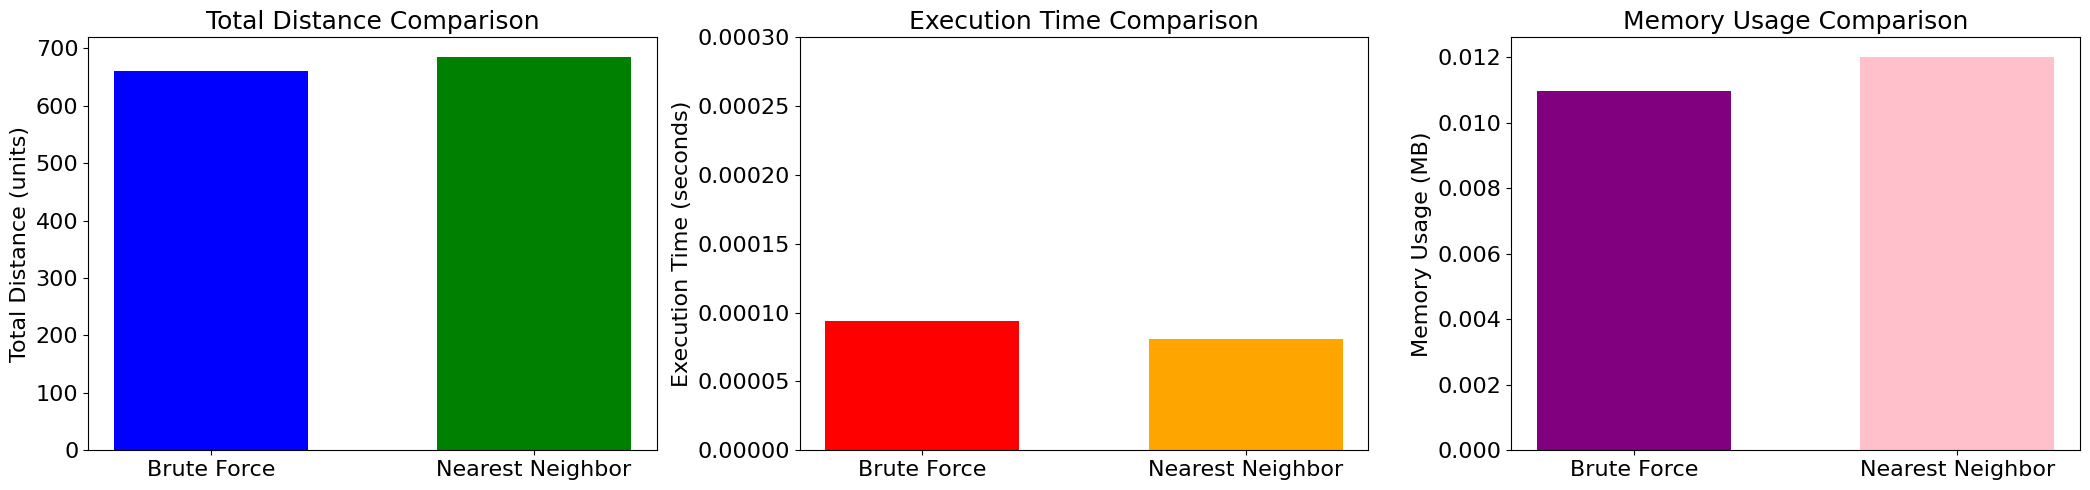

+------------------+------------------------+--------------------------+-------------------+
|    Algorithm     | Total Distance (units) | Execution Time (seconds) | Memory Usage (MB) |
+------------------+------------------------+--------------------------+-------------------+
|   Brute Force    |         660.0          |  9.369850158691406e-05   |     0.010987      |
| Nearest Neighbor |   685.0999999999999    |  8.058547973632812e-05   |     0.012011      |
+------------------+------------------------+--------------------------+-------------------+


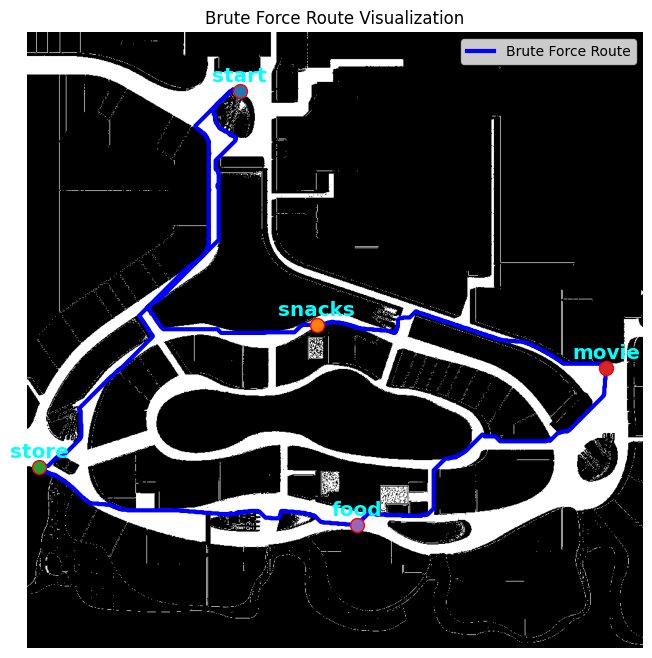

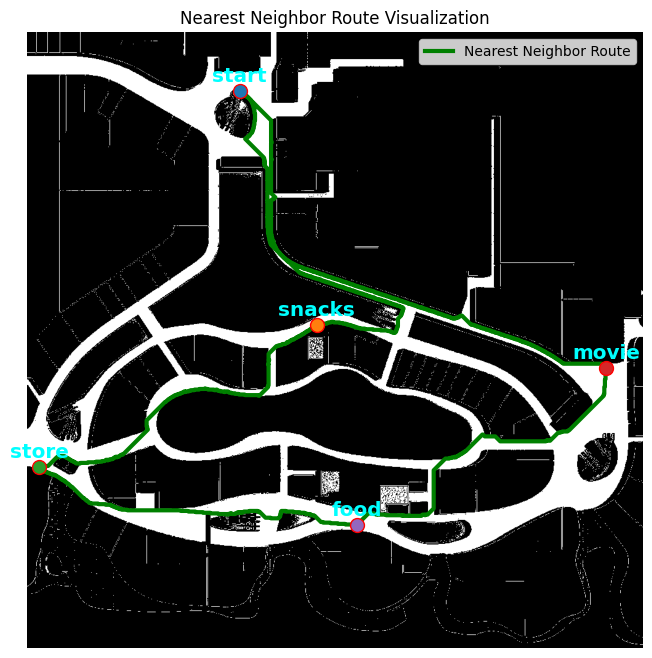

In [6]:
import time
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tracemalloc
import imageio
from tabulate import tabulate

# Record the start time for brute force
brute_force_start_time = time.time()
optimal_route, optimal_distance = brute_force_tsp(start, loc)
brute_force_time = time.time() - brute_force_start_time

# Record the start time for nearest neighbor
nearest_neighbor_start_time = time.time()
nn_route, nn_distance = nearest_neighbor(start, loc, distances)
nearest_neighbor_time = time.time() - nearest_neighbor_start_time

# Measure memory usage for brute force algorithm
tracemalloc.start()
brute_force_start_time = time.time()
optimal_route, optimal_distance = brute_force_tsp(start, loc)
brute_force_time = time.time() - brute_force_start_time
current_bf, peak_bf = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Measure memory usage for nearest neighbor algorithm
tracemalloc.start()
nearest_neighbor_start_time = time.time()
nn_route, nn_distance = nearest_neighbor(start, loc, distances)
nearest_neighbor_time = time.time() - nearest_neighbor_start_time
current_nn, peak_nn = tracemalloc.get_traced_memory()
tracemalloc.stop()


comparison_data = {
    'Algorithm': ['Brute Force', 'Nearest Neighbor'],
    'Total Distance (units)': [optimal_distance, nn_distance],
    'Execution Time (seconds)': [brute_force_time, nearest_neighbor_time],
    'Memory Usage (MB)': [peak_bf / 10**6, peak_nn / 10**6]
}

# Convert the dictionary to a DataFrame for easy tabulation
comparison_df = pd.DataFrame(comparison_data)


# Plot the comparison as bar charts
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
bar_width = 0.6  # Adjust the width of the bars
label_fontsize = 16  # Adjust the fontsize for labels
title_fontsize = 18  # Adjust the fontsize for titles

# Total Distance Comparison
axes[0].bar(comparison_df['Algorithm'], comparison_df['Total Distance (units)'], color=['blue', 'green'], width=bar_width)
axes[0].set_title('Total Distance Comparison', fontsize=title_fontsize)
axes[0].set_ylabel('Total Distance (units)', fontsize=label_fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=label_fontsize)

# Execution Time Comparison
axes[1].bar(comparison_df['Algorithm'], comparison_df['Execution Time (seconds)'], color=['red', 'orange'], width=bar_width)
axes[1].set_title('Execution Time Comparison', fontsize=title_fontsize)
axes[1].set_ylabel('Execution Time (seconds)', fontsize=label_fontsize)
axes[1].set_ylim([0, 0.0003])  # Adjusted as per your previous request
axes[1].tick_params(axis='both', which='major', labelsize=label_fontsize)

# Memory Usage Comparison
axes[2].bar(comparison_df['Algorithm'], comparison_df['Memory Usage (MB)'], color=['purple', 'pink'], width=bar_width)
axes[2].set_title('Memory Usage Comparison', fontsize=title_fontsize)
axes[2].set_ylabel('Memory Usage (MB)', fontsize=label_fontsize)
axes[2].tick_params(axis='both', which='major', labelsize=label_fontsize)

# Show the plots
plt.tight_layout()
plt.show()

# Use tabulate to print a table
print(tabulate(comparison_df, headers='keys', tablefmt='pretty', showindex=False))

# Visualize the route for brute force algorithm
aggregated_paths_bf = aggregate_paths(optimal_route)
x_bf, y_bf = zip(*aggregated_paths_bf)
plt.figure(figsize=(12, 8))
plt.plot(x_bf, y_bf, color='blue', linewidth=3, label='Brute Force Route')
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.title('Brute Force Route Visualization')
plt.axis('off')
plt.legend()
plt.show()

# Visualize the route for nearest neighbor algorithm
aggregated_paths_nn = aggregate_paths(nn_route)
x_nn, y_nn = zip(*aggregated_paths_nn)
plt.figure(figsize=(12, 8))
plt.plot(x_nn, y_nn, color='green', linewidth=3, label='Nearest Neighbor Route')
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.title('Nearest Neighbor Route Visualization')
plt.axis('off')
plt.legend()
plt.show()
